## Задание

Увеличение количества эпох (шагов обучения) существенно повышает качество модели. Но есть и другие способы - поэкспериментируйте например с добавлением новых свёрточных или линейных слоёв, размерами фильтров и их количеством. В процессе экспериментов избегайте переобучения - когда модель показывает отличные результаты на обучающей выборке, но невысокие на тестовой.

В следующем занятии мы займёмся экспериментами с уже обученными моделями.

In [12]:
import time
import numpy as np

import torch
import torch.nn.functional as F
from torch import optim, nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [13]:
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step


def plot_learning_curve(loss_array: list):
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(loss_array)), loss_array)
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [3]:
# инициализируем девайс
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Baseline

In [4]:
INPUT_SIZE = 3*32*32   # Размер изображения в точках * количество цветов
NUM_CLASSES = 10       # Количество распознающихся классов (10 видов изображений)
N_EPOCHS = 2           # Количество эпох
BATCH_SIZE = 4        # Размер мини-пакета входных данных
LR = 0.001             # Скорость обучения

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

cifar_trainset = dsets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = dsets.CIFAR10(root='./data', train=False, download=True, transform=transform)
print(len(cifar_trainset))
print(len(cifar_testset))

Files already downloaded and verified
Files already downloaded and verified
50000
10000


In [6]:
train_loader = torch.utils.data.DataLoader(dataset=cifar_trainset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=cifar_testset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

In [7]:
class CifarModel(nn.Module):
    def __init__(self):
        super(CifarModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
start_time = time.time()

model = CifarModel()
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(N_EPOCHS):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        loss = train_step(images, labels)

end_time = time.time() - start_time

# print(model.state_dict())
print(loss)
print("Total duration (minutes):", end_time / 60)

1.4458816051483154
Total duration (minutes): 0.8668748577435811


In [9]:
with torch.no_grad(): # проверяем на тестовой выборке
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Точность: {} %'.format(100 * correct / total))

Точность: 56.05 %


In [10]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(4):
    print('Точность для %5s : %2d %%' % (
        labels[i], 100 * class_correct[i] / class_total[i]))

Точность для tensor(3, device='cuda:0') : 71 %
Точность для tensor(5, device='cuda:0') : 76 %
Точность для tensor(1, device='cuda:0') : 27 %
Точность для tensor(7, device='cuda:0') : 38 %


## Experiments

### Version-1

Изменения: 

- Увеличим кол-во эпох
- Увеличим размер батча
- Внёсем небольшие изменения ядра свёрточных слоёв

In [14]:
INPUT_SIZE = 3 * 32 * 32   # Размер изображения в точках * количество цветов
NUM_CLASSES = 10           # Количество распознающихся классов (10 видов изображений)
N_EPOCHS = 5               # Количество эпох
BATCH_SIZE = 8             # Размер мини-пакета входных данных
LR = 0.001                 # Скорость обучения

In [15]:
class FirstCNN(nn.Module):
    def __init__(self):
        super(FirstCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
start_time = time.time()

model = FirstCNN()
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_step = make_train_step(model, loss_fn, optimizer)

epochs_loss = []
for epoch in range(N_EPOCHS):
    one_epoch_loss = []
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        loss = train_step(images, labels)
        one_epoch_loss.append(loss)
    epochs_loss.append(np.mean(one_epoch_loss))

end_time = time.time() - start_time

# print(model.state_dict())
print(loss)
print("Total duration (minutes):", end_time / 60)

0.8782951831817627
Total duration (minutes): 2.1349944432576495


In [18]:
with torch.no_grad(): # проверяем на тестовой выборке
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Точность: {} %'.format(100 * correct / total))

Точность: 59.94 %


In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(4):
    print('Точность для %5s : %2d %%' % (
        labels[i], 100 * class_correct[i] / class_total[i]))

Точность для tensor(3, device='cuda:0') : 58 %
Точность для tensor(5, device='cuda:0') : 57 %
Точность для tensor(1, device='cuda:0') : 41 %
Точность для tensor(7, device='cuda:0') : 37 %


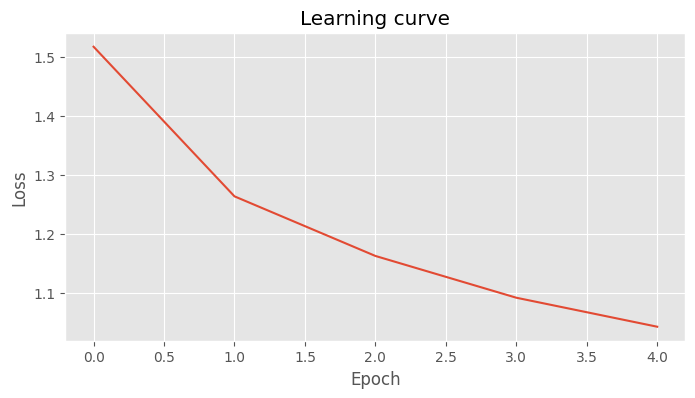

In [21]:
plot_learning_curve(epochs_loss)

### Version-2

In [24]:
INPUT_SIZE = 3 * 32 * 32   # Размер изображения в точках * количество цветов
NUM_CLASSES = 10           # Количество распознающихся классов (10 видов изображений)
N_EPOCHS = 5               # Количество эпох
BATCH_SIZE = 8             # Размер мини-пакета входных данных
LR = 0.001                 # Скорость обучения

In [25]:
class SecondCNN(nn.Module):
    def __init__(self):
        super(SecondCNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [26]:
start_time = time.time()

model = SecondCNN()
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(N_EPOCHS):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        loss = train_step(images, labels)

end_time = time.time() - start_time

# print(model.state_dict())
print(loss)
print("Total duration (minutes):", end_time / 60)

2.083653450012207
Total duration (minutes): 3.4213518102963767


In [27]:
with torch.no_grad(): # проверяем на тестовой выборке
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Точность: {} %'.format(100 * correct / total))

Точность: 64.13 %


In [28]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(4):
    print('Точность для %5s : %2d %%' % (
        labels[i], 100 * class_correct[i] / class_total[i]))

Точность для tensor(3, device='cuda:0') : 62 %
Точность для tensor(5, device='cuda:0') : 78 %
Точность для tensor(1, device='cuda:0') : 44 %
Точность для tensor(7, device='cuda:0') : 63 %


### Version-3

In [ ]:
INPUT_SIZE = 3 * 32 * 32   # Размер изображения в точках * количество цветов
NUM_CLASSES = 10           # Количество распознающихся классов (10 видов изображений)
N_EPOCHS = 5               # Количество эпох
BATCH_SIZE = 8             # Размер мини-пакета входных данных
LR = 0.001                 # Скорость обучения

In [35]:
class CifarModel(nn.Module):
    def __init__(self):
        super(CifarModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [43]:
class ThirdCNN(nn.Module):
    def __init__(self):
        super(ThirdCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [44]:
start_time = time.time()

model = ThirdCNN()
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(N_EPOCHS):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        loss = train_step(images, labels)

end_time = time.time() - start_time

# print(model.state_dict())
print(loss)
print("Total duration (minutes):", end_time / 60)

0.8637257218360901
Total duration (minutes): 2.3236048460006713


In [45]:
with torch.no_grad(): # проверяем на тестовой выборке
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Точность: {} %'.format(100 * correct / total))

Точность: 70.49 %


In [46]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(4):
    print('Точность для %5s : %2d %%' % (
        labels[i], 100 * class_correct[i] / class_total[i]))

Точность для tensor(3, device='cuda:0') : 66 %
Точность для tensor(5, device='cuda:0') : 85 %
Точность для tensor(1, device='cuda:0') : 58 %
Точность для tensor(7, device='cuda:0') : 54 %
